## Procedure for fitting the model to IB data

For this procedure we simulate the model for many combinations of the parameters and find the one that best matches the observed data. 

### Epidemiological data

Time series available are

* Deaths (official data)
* Deaths (press data)
* UCI patients
* Recovered patients
* Infected patients
* Hospitalized patients

### Results of the model

Time series from the model

* Infected
* Recovered

### Fitting model to data

In order to fit the model to the data we proceed in the following way for each combination of parameters:

1. Fix a proportion of recovered patients that actually die. ($\mu_D$)
2. Shift rescaled curve of recovered patients by tau from the model to best fit the curve of deaths from the data. The best fit is assessed by a $\chi^2$ function.
3. With that tau move also the curve of infected from the model and rescale it to best match the curve of UCI patients. Best value of this variable also given by Chi squared. ($\mu_{UCI}$)
4. Assign to this set of parameters the $\chi^2$ that is the sum of the ones in 2. and 3. and save it together with the parameter values, the proportion of deaths and the obtained parameters tau and proportion of infected in UCI.

From all the $\chi^2$ values choose the one that is minimum.

## Code

Import necessary modules.

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os
import glob
import sys
from matplotlib.ticker import ScalarFormatter
from matplotlib.dates import date2num, datestr2num

In [3]:
def shift(df, Ndays):
    '''
    shift(df, Ndays) function: 
        shift the dataframe df Ndays to the past
    Inputs:
        >> df: dataframe to be shifted (the one of simulations). Has to have a column 'Día'
        >> Ndays: integer number of days to shift dataframe
    Outputs:
        << dfnew: shifted dataframe.
    '''
    dates = list(df['Día'])
    timedelta = dt.timedelta(days = Ndays)
    newdates = [dates[i] - timedelta for i in range(len(dates))]
    dfnew = df.copy()
    dfnew['Día'] = newdates
    return dfnew

In [41]:
def chi2(df,
         cname1,
         cname2,
         par,
         chi2_type = 'linear', minvalue = 1):
    '''
    chi2(df, cname1, cname2, par) function: 
        compute sum of squares of the differences between the column cname1 and the column cnam2*par.
        The sum is restricted to those points where the column cname1 has data (notna) which are 
        over minvalue.
    Inputs:
        >> df: dataframe merged with epi data (cname1) and simu data (cname2)
        >> cname1: str name of the column of epi data.
        >> cname2: str name of the column of simu data.
        >> par: float parameter rescaling the curve in cname2
        >> chi_type: str that tells how to compute chi^2
                Optional, default is 'linear'
                'linear': sum of squares of the differences
                'log': sum of squares of the differences of logs
                'relative': sum of squares of the difference divided by the value of the data
        >> minvalue: int minimum value of the datapoints to fit (minvalue included)
                Optional, default is 1
    Outputs:
        << chi2_: float sum of squares of the differences between the column cname1 and the column cnam2*par.
    '''
    chi2_ = 0.0
    df2_ = df[df[cname1].notna()] # get rid of nans
    df2_ = df2_[(df2_[[cname1]] >= minvalue).all(axis=1)] # get rid of values below minvalue
    a = np.array(df2_[cname1])
    b = np.array(df2_[cname2])*par
    if chi2_type == 'linear':
        chi2_ = np.sum(np.square(a - b))
    elif chi2_type == 'log':
        a = np.log(a)
        b = np.log(b)
        chi2_ = np.sum(np.square(a - b))
    elif chi2_type == 'relative':
        chi2_ = np.sum(np.square(a - b)/a)
    del df2_
    return chi2_

In [5]:
def best_fit(df_epi,
             fname_simu,
             mu_D = 0.01,
             Ndays = 50,
             weight = 0.5,
             chi2_type = 'linear',
             minvalue = 1):
    '''
    best_fit(df_epi, fname_simu [, mu_D = 0.01, Ndays = 50, weight = 0.5, chi2_type = 'linear', minvalue = 1]) function: 
        Given a death rate mu_D and the results of a simulation this function first fits the recovered
        from the simulation multiplied by the death rate mu_D to the deaths from epi data by shifting 
        the recovered*mu_D in the simu by dayshift minimising the chi2_M. Then with that value for dayshift 
        the infected from the simu are shifted and a UCI rate is computed to minimise a chi2 with respect 
        to the epi UCIs (chi2_UCI). In the end one obtains the total chi2 which is the weighted sum of both
        chi2,the dayshift and the UCI rate mu_UCI
    Inputs:
        >> df_epi: dataframe with epi data
        >> fname_simu: str name of the file with the results of the simulation
        >> mu_D: float death rate which rescales the recovered from simu to match deaths from epi. 
                (optional, default is 0.01)
        >> Ndays: int maximum days tried for the dayshift
                (optional, default is 50)
        >> weight: float how to weight the chi2. 
                The chi2 of the deaths is weighted by weight and the one for UCI with (1-weight)
                (optional, default is 0.5)
        >> chi_type: str that tells how to compute chi^2
                Optional, default is 'linear'
                'linear': sum of squares of the differences
                'log': sum of squares of the differences of logs
                'relative': sum of squares of the difference divided by the value of the data
        >> minvalue: int minimum value of the datapoints to fit (minvalue included)
                Optional, default is 1
    Outputs:
        << chichi: float weighted sum of chi2 for the best fit. 
                chichi = weight*chi_2_M + (1.0-weight)*chi_2_UCI
        << dayshift: int number of days that the simu has to be shifted for the best fit.
        << mu_UCI: float UCI rate to rescale infected that best fits the UCI from epi data.
                This parameter is scanned in the range (start = 0.00001, end = 0.005, step = 0.00001)
    '''
    df_simu = read_csv_VME(fname_simu)
    chi_2_M = float("inf")
    dayshift = 0
    for iday in range(Ndays):
        df_shifted = shift(df_simu, iday)
        df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
        chichi = chi2(df_merged, 'M', 'average_recover', mu_D, chi2_type = 'linear', minvalue = 1)
        if chichi < chi_2_M:
            chi_2_M = chichi
            dayshift = iday
    v1=np.arange(0.00001,0.005,0.00001)
    df_shifted = shift(df_simu, dayshift)
    df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
    #print(df_merged.head())
    #sys.exit()
    chi_2_UCI = float("inf")
    mu_UCI = 0.0
    for muci in v1:
        chichi = chi2(df_merged, 'UCI', 'average_infected', muci, chi2_type = 'linear', minvalue = 1)
        if chichi < chi_2_UCI:
            chi_2_UCI = chichi
            mu_UCI = muci
    chichi = weight*chi_2_M + (1.0-weight)*chi_2_UCI
    return chichi, dayshift, mu_UCI

In [32]:
def read_csv_VME(fname):
    '''
    read_csv_VME(fname) function: 
        reads results of simulations provided by the codes of VME. This function also adds a column 'Día'
        with datetime objects having the date.
    Inputs:
        >> fname: str path + filename to access the simulation data
    Outputs:
        << df: dataframe with the simulation data and an added column 'Día' with the dates as datetime objects
    '''
    fname2 = fname.split('.dat')[0]+'_format0.dat'
    os.system("awk '$1=$1' "+fname+" > "+fname2)
    df = pd.read_csv(fname2, sep = ' ')
    os.system('rm '+fname2)
    date0 = dt.datetime(day = 29, month = 2, year = 2020)
    datenums = list(df['#time'])
    dates = [date0 + dt.timedelta(days = datenums[i]) for i in range(len(datenums))]
    df['Día'] = dates
    return df

In [30]:
def limit_tseries(x, y, start_date, end_date):    
    '''
    limit_tseries(x, y, start_date, end_date) function: 
        limits a time series to the dates provided (both dates included)
    Inputs:
        >> x: list of datetime objects that provide dates for the data in y
        >> y: list with the data
        >> start_date: datetime object date of start of the resulting timeseries
        >> end_date: datetime object date of end of the resulting timeseries
    Outputs:
        << xlimit: list of datetime objects that provide dates for the data in y restricted to specified dates
        << ylimit: list with the data restricted to specified dates
    '''
    ddays = (end_date - start_date).days
    xlimit = []
    ylimit = []
    for i in range(len(x)):
        dd = (x[i] - start_date).days
        if dd >=0 and dd <= ddays:
            xlimit.append(x[i])
            ylimit.append(y[i])
    return xlimit, ylimit

Read epidemic data.

In [8]:
#read epi data and make day a datetime object
df_epi = pd.read_csv('../data/epi_data_IB.csv')
df_epi['Día'] = pd.to_datetime(df_epi['Día'], format = '%d/%m/%Y', dayfirst = True)
df_epi.head()

,Mpres,I,14d,H,UCI,M,Curad,NuevoI,Día
0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-26
1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-27
2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-01
3,NaN,2,0.17,NaN,0.0,0.0,NaN,NaN,2020-03-02
4,NaN,5,0.43,NaN,0.0,0.0,NaN,NaN,2020-03-03


weight = 0.5:

0.01 199.63748566670535 ../results/time_av_5_18_0.30000000000000004.dat 37 0.00027000000000000006
0.006 322.374997645448 ../results/time_av_5_18_0.30000000000000004.dat 39 0.00022
0.034 263.3104445407316 ../results/time_av_6_19_0.4.dat 33 0.00041000000000000005

weight = 1.0:

0.01 88.20966300000002 ../results/time_av_6_19_0.30000000000000004.dat 43 0.00029000000000000006
0.006 90.36387260000001 ../results/time_av_6_18_0.30000000000000004.dat 45 0.00024
0.034 103.08234360000003 ../results/time_av_5_18_0.30000000000000004.dat 31 0.00068

weight = 0.0:

0.01 276.5303541239999 ../results/time_av_5_18_0.4.dat 31 0.0002
0.006 523.173403650896 ../results/time_av_5_18_0.30000000000000004.dat 39 0.00022
0.034 162.43962863731898 ../results/time_av_6_18_0.8.dat 23 0.00019

In [9]:
#weight = 0.5
f = {0.01 : '../results/time_av_5_18_0.30000000000000004.dat',
     0.006 : '../results/time_av_5_18_0.30000000000000004.dat',
     0.034 : '../results/time_av_6_19_0.4.dat'}
day_sh = {0.01 : 37,
          0.006 : 39,
          0.034 : 33}
mu_U = {0.01 : 0.00027,
        0.006 : 0.00022,
        0.034 : 0.00041}
#weight = 1.0
f = {0.01 : '../results/time_av_6_19_0.30000000000000004.dat',
     0.006 : '../results/time_av_6_18_0.30000000000000004.dat',
     0.034 : '../results/time_av_5_18_0.30000000000000004.dat'}
day_sh = {0.01 : 43,
          0.006 : 45,
          0.034 : 31}
mu_U = {0.01 : 0.00029,
        0.006 : 0.00024,
        0.034 : 0.00068}
#weight = 0.0
f = {0.01 : '../results/time_av_5_18_0.4.dat',
     0.006 : '../results/time_av_5_18_0.30000000000000004.dat',
     0.034 : '../results/time_av_6_18_0.8.dat'}
day_sh = {0.01 : 31,
          0.006 : 39,
          0.034 : 23}
mu_U = {0.01 : 0.0002,
        0.006 : 0.00022,
        0.034 : 0.00019}

In [401]:
files = glob.glob("../results/time_av_*")
#print(files)
percents = [0.01, 0.006, 0.034]
w = 0.5
f = {}
day_sh = {}
mu_U = {}
for perc in percents:
    chi_2 = float("inf")
    for fname in files:
        params = fname.split('.dat')[0].split('_')[2:]
        params[0] = int(params[0])
        params[1] = int(params[1])
        params[2] = np.round(float(params[2]),1)
        chichi, dayshift_, mu_UCI_ = best_fit(df_epi,
                                              fname_simu = fname,
                                              mu_D = perc,
                                              weight = w,
                                              chi2_type = 'linear',
                                              minvalue = 1)
        if chichi < chi_2:
            chi_2 = chichi
            fgood = fname
            dayshift = dayshift_
            mu_UCI = mu_UCI_
    f[perc] = fgood
    day_sh[perc] = dayshift
    mu_U[perc] = mu_UCI
    #print(list(best_fit(df_epi, fname_simu = fname, mu_D = 0.01)))
    print(perc, chi_2, fgood, dayshift, mu_UCI)

0.01 233.4930982889898 ../results/time_av_5_18_0.30000000000000004.dat 37 0.00027000000000000006
0.006 353.357129136666 ../results/time_av_5_18_0.30000000000000004.dat 39 0.00022
0.034 321.5773567919314 ../results/time_av_6_19_0.5.dat 29 0.00031000000000000005


In [33]:
#datos reales
df2 = df_epi[df_epi['M'].notna()]
x_M = np.array(df2['Día'])
y_M = np.array(df2['M'])

df2 = df_epi[df_epi['UCI'].notna()]
x_UCI = np.array(df2['Día'])
y_UCI = np.array(df2['UCI'])

start_date = dt.datetime.strptime(str(x_M[-1]), '%Y-%m-%dT%H:%M:%S.%f000')
end_date = start_date + dt.timedelta(days = 7)

del df2

#resultados modelo
    #prediccion con mu_D 1%
df_simu = read_csv_VME(f[0.01])
df_simu = shift(df_simu, day_sh[0.01])

x_model = list(df_simu['Día'])
y_M_model = np.array(df_simu['average_recover'])*0.01
y_UCI_model = np.array(df_simu['average_infected'])*mu_U[0.01]

x_model2, y_M_model = limit_tseries(x_model, y_M_model, start_date, end_date)
x_model, y_UCI_model = limit_tseries(x_model, y_UCI_model, start_date, end_date)
x_model2 =[]

    #bandas de predicción

    #min con mu_D 0.6%
df_simu = read_csv_VME(f[0.006])
df_simu = shift(df_simu, day_sh[0.006])

x_model_min = list(df_simu['Día'])
y_M_model_min = np.array(df_simu['average_recover'])*0.006
y_UCI_model_min = np.array(df_simu['average_infected'])*mu_U[0.006]

x_model_min2, y_M_model_min = limit_tseries(x_model_min, y_M_model_min, start_date, end_date)
x_model_min, y_UCI_model_min = limit_tseries(x_model_min, y_UCI_model_min, start_date, end_date)
x_model_min2 =[]

    #max con mu_D 3.4%
df_simu = read_csv_VME(f[0.034])
df_simu = shift(df_simu, day_sh[0.034])

x_model_max = list(df_simu['Día'])
y_M_model_max = np.array(df_simu['average_recover'])*0.034
y_UCI_model_max = np.array(df_simu['average_infected'])*mu_U[0.034]

x_model_max2, y_M_model_max = limit_tseries(x_model_max, y_M_model_max, start_date, end_date)
x_model_max, y_UCI_model_max = limit_tseries(x_model_max, y_UCI_model_max, start_date, end_date)
x_model_max2 =[]

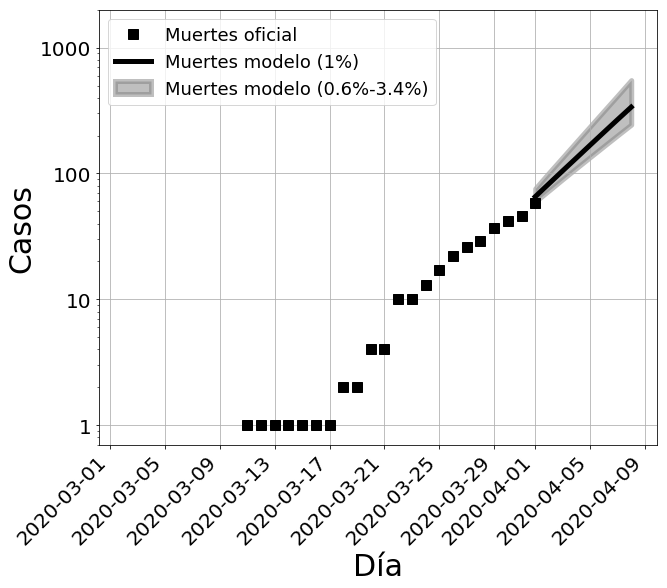

In [37]:
#pintar gráficas de muertes
plt.figure(figsize = (10, 8))

plt.plot(x_M, y_M, 'ks', label = 'Muertes oficial', ms = 10)
plt.plot(x_model, y_M_model, c = 'k', label= 'Muertes modelo (1%)', lw = 5)
plt.fill_between(x_model_min, y_M_model_min, y_M_model_max,
                 color = 'gray', 
                 label= 'Muertes modelo (0.6%-3.4%)',
                 lw = 5,
                 alpha = 0.5)
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.grid()
plt.yscale('log')
plt.xlabel('Día', fontsize = 30)
plt.ylabel('Casos', fontsize = 30)
#plt.xlim((15,35))
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.ylim((0.7,2000))
#plt.title('Muertes', fontsize = 35)
plt.xticks(rotation = 45)
plt.legend(fontsize = 18, loc = 2)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
today = dt.datetime.now()
plt.savefig('../figures/muertes_%02i_%02i_%4i.png' % 
            (today.day, today.month, today.year), 
            bbox_inches='tight')

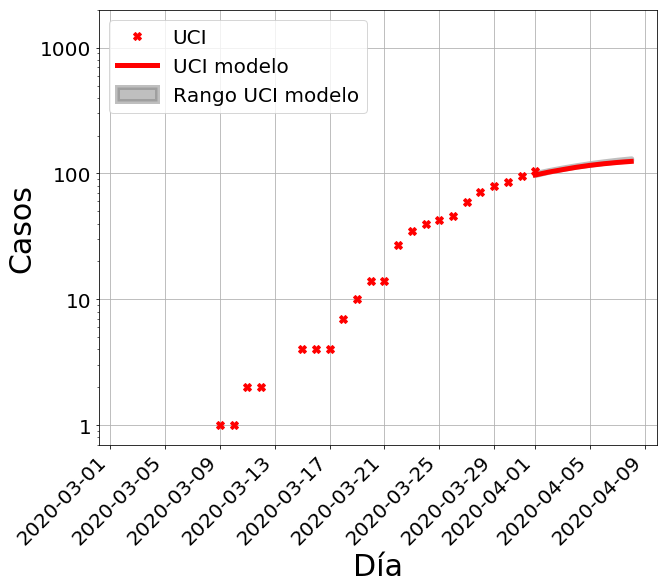

In [39]:
#pintar gráficas de UCI
plt.figure(figsize = (10, 8))

plt.plot(x_UCI, y_UCI, 'rX', label = 'UCI', ms = 8)

plt.plot(x_model, y_UCI_model, c = 'r', label= 'UCI modelo', lw = 5)
plt.fill_between(x_model_min, y_UCI_model_min, y_UCI_model_max,
                 color = 'gray', 
                 label= 'Rango UCI modelo',
                 lw = 5,
                 alpha = 0.5)

ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.grid()
plt.yscale('log')
plt.xlabel('Día', fontsize = 30)
plt.ylabel('Casos', fontsize = 30)
#plt.xlim((15,35))
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.ylim((0.7,2000))
#plt.title('Muertes', fontsize = 35)
plt.xticks(rotation = 45)
plt.legend(fontsize = 20, loc = 2)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
today = dt.datetime.now()
plt.savefig('../figures/uci_%02i_%02i_%4i.png' % 
            (today.day, today.month, today.year), 
            bbox_inches='tight')

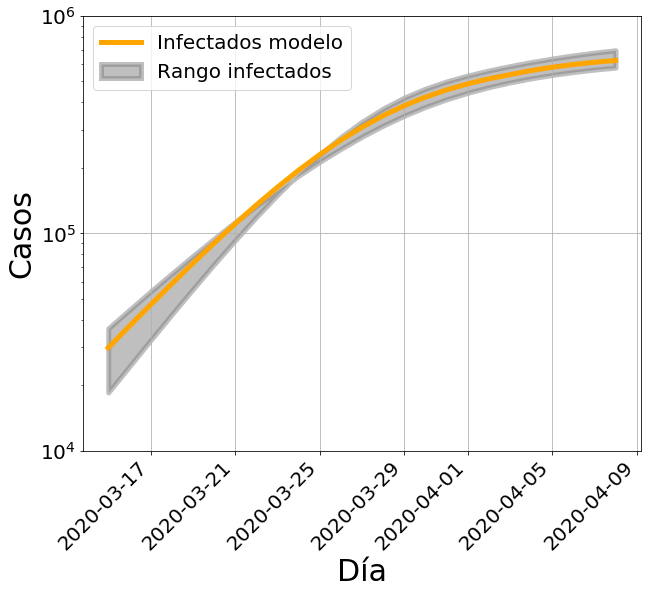

In [38]:
#pintar gráficas de infectados
plt.figure(figsize = (10, 8))

df_simu = read_csv_VME(f[0.01])
df_simu = shift(df_simu, day_sh[0.01])
x = df_simu['Día']
y = df_simu['average_infected']

df_simu = read_csv_VME(f[0.006])
df_simu = shift(df_simu, day_sh[0.006])
x_min = df_simu['Día']
y_min = df_simu['average_infected']

df_simu = read_csv_VME(f[0.034])
df_simu = shift(df_simu, day_sh[0.034])
x_max = df_simu['Día']
y_max = df_simu['average_infected']

start_date = dt.datetime(day = 15, month = 3, year = 2020)
end_date = dt.datetime(day = 8, month = 4, year = 2020)

x, y = limit_tseries(x, y, start_date, end_date)
x_min, y_min = limit_tseries(x_min, y_min, start_date, end_date)
x_max, y_max = limit_tseries(x_max, y_max, start_date, end_date)

plt.plot(x, y, 'orange', label = 'Infectados modelo', lw = 5)

plt.fill_between(x, y_min, y_max,
                 color = 'gray', 
                 label= 'Rango infectados',
                 lw = 5,
                 alpha = 0.5)

ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.grid()
plt.yscale('log')
plt.xlabel('Día', fontsize = 30)
plt.ylabel('Casos', fontsize = 30)
#plt.xlim((15,35))
#ax.yaxis.set_major_formatter(ScalarFormatter())
plt.ylim((10000,1000000))
#plt.title('Muertes', fontsize = 35)
plt.xticks(rotation = 45)
plt.legend(fontsize = 20, loc = 2)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
today = dt.datetime.now()
plt.savefig('../figures/infectados_%02i_%02i_%4i.png' % 
            (today.day, today.month, today.year), 
            bbox_inches='tight')

Read data from simulations (this has to be converted into a loop over all the simulation data files).

In [73]:
#read simulation data and make time into date as datetime object 
#and put it into new column 'Día' to later merge with df_epi
df_simu = pd.read_csv('../results/time_ave_r_sd_i_sd_format0.csv', sep = ' ')
#date0 = dt.datetime.strptime('29/02/2020', '%d/%m/%Y')
date0 = dt.datetime(day = 29, month = 2, year = 2020)
datenums = list(df_simu['time'])
dates = [date0 + dt.timedelta(days = datenums[i]) for i in range(len(datenums))]
df_simu['Día'] = dates
df_simu.head()

,time,average_recover,sd_R,av_Infected,sd_I,Día
0,15,1.0,0.000000,19.7,7.376313,2020-03-15
1,16,1.0,0.000000,27.0,11.081516,2020-03-16
2,17,1.0,0.000000,34.8,13.075167,2020-03-17
3,18,1.0,0.000000,46.4,17.442477,2020-03-18
4,19,1.6,0.663325,59.2,22.569005,2020-03-19


In [75]:
df_shifted = shift(df_simu, 0)
df_shifted.head()

,time,average_recover,sd_R,av_Infected,sd_I,Día
0,15,1.0,0.000000,19.7,7.376313,2020-03-15
1,16,1.0,0.000000,27.0,11.081516,2020-03-16
2,17,1.0,0.000000,34.8,13.075167,2020-03-17
3,18,1.0,0.000000,46.4,17.442477,2020-03-18
4,19,1.6,0.663325,59.2,22.569005,2020-03-19


In [76]:
# merging the datasets
df_merged = pd.merge(df_shifted, df_epi, on="Día")
df_merged.head()

,time,average_recover,sd_R,av_Infected,sd_I,Día,Mpres,I,14d,H,UCI,M,Curad,NuevoI
0,15,1.0,0.000000,19.7,7.376313,2020-03-15,1.0,73,6.18,NaN,4.0,1.0,NaN,NaN
1,16,1.0,0.000000,27.0,11.081516,2020-03-16,1.0,92,7.83,NaN,4.0,1.0,NaN,NaN
2,17,1.0,0.000000,34.8,13.075167,2020-03-17,2.0,112,9.31,NaN,4.0,1.0,NaN,NaN
3,18,1.0,0.000000,46.4,17.442477,2020-03-18,2.0,169,14.18,NaN,7.0,2.0,NaN,NaN
4,19,1.6,0.663325,59.2,22.569005,2020-03-19,3.0,203,17.14,NaN,10.0,2.0,NaN,NaN


In [164]:
Ndays = 30
chichi = [None]*30
df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
for iday in range(Ndays):
    df_shifted = shift(df_simu, iday)
    df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
    chichi[iday], par = chi2(df_merged, 'M', 'average_recover', 0.001)
chichi = np.array(chichi)
dayshift = int(np.where(chichi == np.min(chichi))[0])
print(dayshift)

29


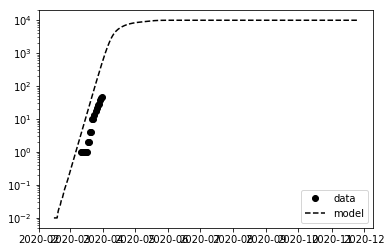

In [165]:
df_shifted = shift(df_simu, dayshift)
df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
x_off = df_merged['Día']
y_off = np.array(df_merged['M'])
x_mod = df_shifted['Día']
y_mod = np.array(df_shifted['average_recover'])*0.01
plt.plot(x_off, y_off, 'ko', label = 'data')
plt.plot(x_mod, y_mod, 'k--', label = 'model')
plt.legend()
plt.yscale('log')

In [168]:
v1=np.arange(0.00001,0.005,0.00001)
chi_2 = dict()
df_shifted = shift(df_simu, dayshift)
df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
for par in v1:
    chi_2[par], kk = chi2(df_merged, 'UCI', 'av_Infected', par)
minchi = np.min(list(chi_2.values()))
print(minchi)
for key, value in chi_2.items():
    if value == minchi:
        mu_uci = key
        print(mu_uci)

552.5613348023842
0.00018


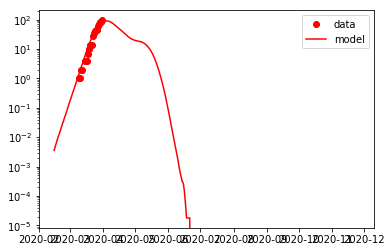

In [167]:
df_shifted = shift(df_simu, dayshift)
df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
x_off = df_merged['Día']
y_off = np.array(df_merged['UCI'])
x_mod = df_shifted['Día']
y_mod = np.array(df_shifted['av_Infected'])*mu_uci
plt.plot(x_off, y_off, 'ro', label = 'data')
plt.plot(x_mod, y_mod, 'r-', label = 'model')
plt.legend()
plt.yscale('log')